In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = 'global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

#DIR_WEIGHTS = 'global-wheat-detection-public'

#WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn_best.pth'
WEIGHTS_FILE = 'fasterrcnn_resnet50_fpn.pth'

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
print(test_df.shape)

(10, 2)


In [4]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [5]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [6]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [9]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)
        
print(results[0:2])

[{'image_id': 'aac893a91', 'PredictionString': '0.9953 555 529 127 196 0.9927 614 916 80 106 0.9895 70 2 98 162 0.9886 243 86 133 147 0.9876 740 768 81 118 0.9862 590 777 97 121 0.9852 182 568 110 187 0.9845 689 390 127 186 0.9832 27 453 100 158 0.9818 818 695 101 211 0.9748 329 666 121 153 0.9736 358 531 96 85 0.9700 458 859 84 97 0.9553 307 0 72 66 0.9517 239 845 157 101 0.9367 66 855 115 74 0.9138 528 41 163 216 0.9093 93 618 119 75 0.8503 820 919 125 103 0.8325 358 267 101 144 0.7811 826 627 82 116 0.5266 168 2 77 143 0.5258 486 982 81 41 0.5042 332 895 67 67'}, {'image_id': '51f1be19e', 'PredictionString': '0.9903 613 85 155 196 0.9872 505 469 206 114 0.9864 280 479 131 117 0.9843 842 262 134 209 0.9774 20 0 92 73 0.9757 187 929 114 94 0.9748 804 761 111 99 0.9703 1 380 55 102 0.9688 814 92 116 81 0.9656 770 883 147 99 0.9476 699 917 84 90 0.9439 652 787 107 88 0.9360 564 603 112 119 0.9229 52 683 143 223 0.9151 914 565 92 111 0.9077 248 123 108 114 0.9010 346 143 105 174 0.8913 8

In [10]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9953 555 529 127 196 0.9927 614 916 80 106 0...
1,51f1be19e,0.9903 613 85 155 196 0.9872 505 469 206 114 0...
2,f5a1f0358,0.9912 939 430 83 194 0.9909 133 750 173 127 0...
3,796707dd7,0.9850 895 330 114 96 0.9847 375 632 104 126 0...
4,51b3e36ab,0.9969 0 439 103 326 0.9962 233 644 95 161 0.9...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


boxes size = (32, 4)
filtered boxes size = (21, 4)


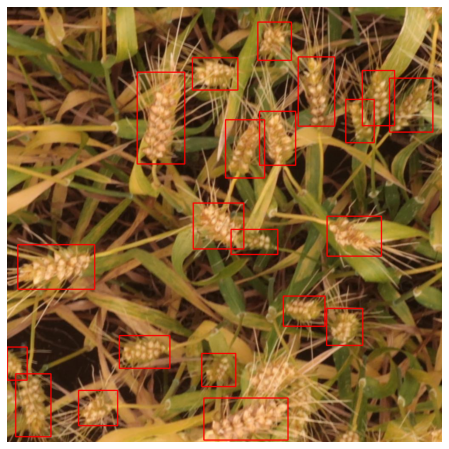

In [14]:
image_index = 0
sample = images[image_index].permute(1,2,0).cpu().numpy()
boxes = outputs[image_index]['boxes'].data.cpu().numpy()
scores = outputs[image_index]['scores'].data.cpu().numpy()
print(f'boxes size = {boxes.shape}')
boxes = boxes[scores >= detection_threshold].astype(np.int32)
print(f'filtered boxes size = {boxes.shape}')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

test_df.to_csv('submission.csv', index=False)